#뉴스기사 크롤링 및 분류

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 웹 이해하기 (1) HTML과 태그

크롤링 (crawling)이란 웹 페이지로부터 데이터를 추출하는 행위를 말한다. 그래서 크롤링하는 소프트웨어는 크롤러(crawler)라고 부른다.

오늘은 네이버 뉴스를 크롤링하고, 크롤링한 네이버 뉴스를 머신 러닝을 통해서 카테고리를 분류해 보는 작업을 해보겠다.

크롤링에 대해서 본격적으로 들어가기 전에, 우리가 데이터를 수집할 웹(web)에 대해서 먼저 간단히 이해해보겠다.

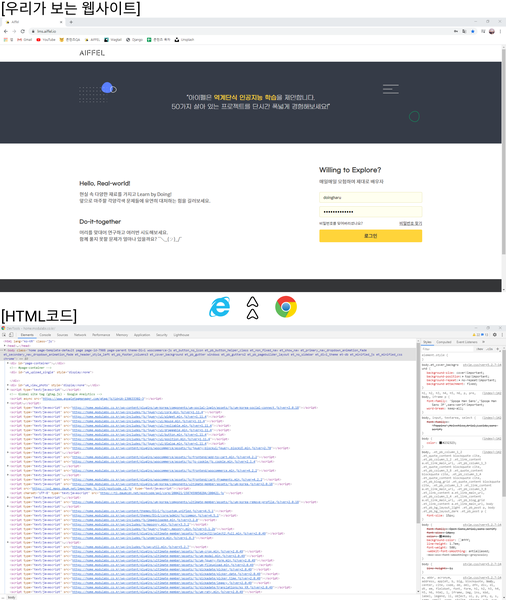

우리는 인터넷 익스플로러, 크롬 등과 같은 '인터넷 브라우저'를 사용하여 인터넷 세상을 돌아다닌다. 인터넷 브라우저를 통해서 NAVER, Facebook과 같은 깔끔하고 예쁜 웹 사이트를 방문할 수 있다. 그런데 이 웹사이트들은 실은 HTML(HyperText Makeup Language)이라는 마크업 언어로 작성된 문서로 구성되어 있다.

 HTML 문서를 살펴보면 수많은 꺾쇠(<>)들의 조합으로 구성된 것을 확인할 수 있다. 아래에 네이버 HTML 소스 코드를 일부이다.




```
<div class="direct_area">
    <a href="http://news.naver.com/" class="link_news" data-clk="newshome">네이버뉴스</a>
    <a href="http://entertain.naver.com/home" class="link_direct" data-clk="entertainment">연예</a>
    <a href="http://sports.news.naver.com/" class="link_direct" data-clk="sports">스포츠</a>
</div>
```



위와 같이 꺽쇠들로 구성된 코드를 태그(Tag)라고 한다. 위의 HTML 코드는 여러 개의 중첩된 태그로 구성되어 있는 셈이다.

### 웹 이해하기 (2) 선택자

#### 선택자(Selector)


원활한 크롤링을 위해서는 HTML 문서 내의 선택자(Selector)를 이해해야 한다. 선택자란 어떤 특정 태그들에 그룹이나 번호를 주는 기능을 말한다. 다음과 같은 HTML 문서가 있다고 해보자.



```
<html> 
    <head> 
    </head> 
    <body> 
        <h1> 장바구니
            <p> 라운드티
                <span> 25 </span> 
                <span> 29000 </span> 
                <span> 의류</span> 
                <a href = 'http://www.naver.com'> 이동 </a> 
            </p> 
            <p> 시계
                <span> 28 </span>
                <span> 32000 </span> 
                <span> 악세서리 </span> 
                <a href = 'http://www.facebook.com'> 이동 </a> 
            </p> 
        </h1> 
    </body> 
</html>
```



위 문서에서 p태그, span 태그, a 태그를 보자. 이 태그들은 한개만 있는 것이 아니라 동일한 태그가 여러 개 반복적으로 있다. p 태그는 2개, span 태그는 6개, a 태그는 2개가 있다.

HTML 문서를 작성할 때, 이렇게 같은 태그가 아무 추가 정보 없이 반복되면 가독성도 안 좋아지고 서로 관계를 가지는 태그들이나 특정 태그만 선택해서 효과를 주고 싶을 때도 일일히 찾아야 하는 번거로움이 있다. 그렇다면 이들 간의 관계나 특정 태그를 정의할 수 있는 방법은 없을까?

가령, 예를 들어 위 HTML 문서에서 '의류'라고 적힌 줄과 '악세사리'라고 적힌 줄이 어떤 동등한 관계에 있따는 것은 짐작이 간다. 그 외에도 '라운드 티'라고 적힌 줄과 '시계'라고 적힌 부줄은 어떤 동등한 관계까 아닐까 추측해 볼 수 있다.

위 HTML 문서에 id와 class라는 선택자(selector)를 추가하면 훨씬 보기도 쉽고, 관리하기가 쉬워진다.

                <html> 
    <head> 
    </head> 
    <body> 
        <h1> 장바구니
            <p id='clothes' class='name' title='라운드티'> 라운드티
                <span class = 'number'> 25 </span> 
                <span class = 'price'> 29000 </span> 
                <span class = 'menu'> 의류</span> 
                <a href = 'http://www.naver.com'> 바로가기 </a> 
            </p> 
            <p id='watch' class='name' title='시계'> 시계
                <span class = 'number'> 28 </span>
                <span class = 'price'> 32000 </span> 
                <span class = 'menu'> 악세서리 </span> 
                <a href = 'http://www.facebook.com'> 바로가기 </a> 
            </p> 
        </h1> 
    </body> 
</html>

위 코드는 id와 class를 기존의 코드에 새로 추가한 코드이다. class 는 비슷한 성격을 가지는 그룹을 정의해서 함께 관리하고 싶을 때 사용한다. 가령, '라운드티'와 '시계'는 'name'이라는 동일한 클래스를 가지고, 29000과 32000은 'price'라는 동일한 클래스를 가지는 것을 볼 수 있다.

반면, 라운드티와 시계는 서로 다른 id를 가진다. 이렇게 작성하면 코드의 가독성도 좋아지지만 class 와 id 에 효과, 구체적으로는 CSS의 스타일을 적용할 때 매우 유용하다.

여기서 중요한 것은 우리는 크롤링을 할 예정이고, 선택자의 개념을 이용해서 크롤링을 보다 용이하게 할 수 있다는 것이다! HTML 문서의 구조와 태그를 이해했다면, 본격적으로 크롤링의 세계로 들어가겠습니다.

### BeautifulSoup 패키지

다시 한 번, 크롤링 이란 웹 페이지로부터 원하는 정보를 추출하는 행위입니다. 앞에서 네이버 HTML 파일을 보며, 이 복잡한 문서에서 어떻게 원하는 태그를 찾아 원하는 정보만 뽑아낼 수 있을지 걱정이다. 하지만, 좋은 뉴스가 있다! BeautifulSoup 라는 파이썬 크롤링 패키지를 사용하면 손쉽게 이 작업을 수행할 수 있다는 것이다. 이 패키지는 HTML이나 XML 문서로부터 원하는 정보를 추출해 준다 (XML은 HTML과 마찬가지로 정보를 표시하는 또다른 규격입니다).

#### BeautifulSoup 사용법

In [2]:
from bs4 import BeautifulSoup

#- HTML 문서를 문자열 html로 저장합니다.
html = '''
<html> 
    <head> 
    </head> 
    <body> 
        <h1> 장바구니
            <p id='clothes' class='name' title='라운드티'> 라운드티
                <span class = 'number'> 25 </span> 
                <span class = 'price'> 29000 </span> 
                <span class = 'menu'> 의류</span> 
                <a href = 'http://www.naver.com'> 바로가기 </a> 
            </p> 
            <p id='watch' class='name' title='시계'> 시계
                <span class = 'number'> 28 </span>
                <span class = 'price'> 32000 </span> 
                <span class = 'menu'> 악세서리 </span> 
                <a href = 'http://www.facebook.com'> 바로가기 </a> 
            </p> 
        </h1> 
    </body> 
</html>
'''

#- BeautifulSoup 인스턴스를 생성합니다.
#- 두번째 매개변수는 분석할 분석기(parser)의 종류입니다.
soup = BeautifulSoup(html, 'html.parser')

맨 아랫 줄에 있는 코드를 볼까? BeautifulSoup(입력 문자열, 'html.parser')라는 코드는 이 입력은 HTML 문법으로 작성되어져 있으니 HTML 문법을 기반으로 파싱하라는 의미이다. 이렇게 인스턴스를 생성하고나면 본격적으로 정보를 가져오는 것은 select()를 가지고 수행할 수 있다.

현재 인스턴스의 이름은 soup이므로 soup.select()를 통해서 정보를 가져온다. select()의 사용 방법은 간단히 요약하면 soup.select('찾는 정보')이다. 구체적으로는 아래와 같이 사용한다.

In [3]:
print(soup.select('body'))

[<body>
<h1> 장바구니
            <p class="name" id="clothes" title="라운드티"> 라운드티
                <span class="number"> 25 </span>
<span class="price"> 29000 </span>
<span class="menu"> 의류</span>
<a href="http://www.naver.com"> 바로가기 </a>
</p>
<p class="name" id="watch" title="시계"> 시계
                <span class="number"> 28 </span>
<span class="price"> 32000 </span>
<span class="menu"> 악세서리 </span>
<a href="http://www.facebook.com"> 바로가기 </a>
</p>
</h1>
</body>]


In [4]:
#body 내부정보
print(soup.select('body'))

[<body>
<h1> 장바구니
            <p class="name" id="clothes" title="라운드티"> 라운드티
                <span class="number"> 25 </span>
<span class="price"> 29000 </span>
<span class="menu"> 의류</span>
<a href="http://www.naver.com"> 바로가기 </a>
</p>
<p class="name" id="watch" title="시계"> 시계
                <span class="number"> 28 </span>
<span class="price"> 32000 </span>
<span class="menu"> 악세서리 </span>
<a href="http://www.facebook.com"> 바로가기 </a>
</p>
</h1>
</body>]


In [5]:
print(soup.select('p'))

[<p class="name" id="clothes" title="라운드티"> 라운드티
                <span class="number"> 25 </span>
<span class="price"> 29000 </span>
<span class="menu"> 의류</span>
<a href="http://www.naver.com"> 바로가기 </a>
</p>, <p class="name" id="watch" title="시계"> 시계
                <span class="number"> 28 </span>
<span class="price"> 32000 </span>
<span class="menu"> 악세서리 </span>
<a href="http://www.facebook.com"> 바로가기 </a>
</p>]


HTML의 요소 간에는 부모-자식 관계가 있다. 한 개의 태그 내에 포함된 태그들은 상위 태그의 자식이 된다. 이번에는 h1 요소의 자식 중 class가 "menu"인 경우만을 출력해 보겠다. BeautifulSoup에서는 class의 이름으로 바로 요소를 가리킬 수 있다.

태그명 h1 자식인 클래스 .name의 자식인 클래스 .menu의 정보를 찾아보자.

In [6]:
print(soup.select('h1 .name .menu'))

[<span class="menu"> 의류</span>, <span class="menu"> 악세서리 </span>]


이번에는 의도적으로 잘못된 입력을 주겠다. 태그명 h1은 태그명 html의 자식이기는 하지만, 바로 아래인 자식은 아닙니다. h1은 body의 자식이지요. 만약, html 의 바로 아래 자식인 h1의 정보를 가져오라고 하면 어떻게 될까?

In [7]:
print(soup.select('html > h1'))

[]


아무런 정보도 출력되지 않았다. 만약 >을 제외하고 soup.select('html h1') 이라고 했다면 어떻게 될지 생각해보자.




In [8]:
soup.select('html h1')

[<h1> 장바구니
             <p class="name" id="clothes" title="라운드티"> 라운드티
                 <span class="number"> 25 </span>
 <span class="price"> 29000 </span>
 <span class="menu"> 의류</span>
 <a href="http://www.naver.com"> 바로가기 </a>
 </p>
 <p class="name" id="watch" title="시계"> 시계
                 <span class="number"> 28 </span>
 <span class="price"> 32000 </span>
 <span class="menu"> 악세서리 </span>
 <a href="http://www.facebook.com"> 바로가기 </a>
 </p>
 </h1>]

h1 정보가 나온다.

### newspaper3k 패키지

In [9]:
!pip install newspaper3k

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


newspaper3k 는 뉴스 데이터를 크롤링하기 위해 만들어진 패키지이다. 사용자가 뉴스 기사의 URL을 전달해주면, 이로부터 뉴스 기사의 제목과 텍스트를 추출할 수 있다.

In [10]:
from newspaper import Article

#- 파싱할 뉴스 기사 주소입니다.
url = 'https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=030&aid=0002881076'

#- 언어가 한국어이므로 language='ko'로 설정해줍니다.
article = Article(url, language='ko')
article.download()
article.parse()

위의 코드를 실행하면 주어진 URL의 뉴스 데이터를 피싱한다. 이때 article의 title에는 뉴스 기사의 제목, article의 text에는 뉴스 기사의 내용이 저장된다. 출력을 통해 확인해보자/

In [11]:
#- 기사 제목을 출력합니다.
print('기사 제목 :')
print(article.title)
print('')

#- 기사 내용을 출력합니다.
print('기사 내용 :')
print(article.text)

기사 제목 :
[AI 사피엔스 시대]자연어처리 기술, 컴퓨팅 파워 경쟁 시대로

기사 내용 :
[Copyright ⓒ 전자신문 & 전자신문인터넷, 무단전재 및 재배포 금지]

주로 아이디어와 기술력으로 경쟁했던 자연어처리 인공지능(AI) 분야는 점차 컴퓨팅 파워 싸움으로 무게 추가 이동하고 있다. 모델이 대형화되면서 향상된 퍼포먼스 확보에 필요한 자금 규모도 커지고 있다. 자칫 대기업 자본력에 휘둘릴 수 있다는 우려도 함께 나온다.자연어처리(NLP)는 인간이 사용하는 언어 체계를 기계가 인식하도록 알고리즘을 디자인하는 기술이다. 흔히 말하는 컴퓨터 혹은 인간과 대화하는 컴퓨터 관련 기술이 포함된다.목적에 따라 세 가지 카테고리로 나뉜다. 인간이 제기한 질문에 자동으로 적절한 답을 찾아주는 '질의응답(QA)', 원하는 업무를 지시했을 때 작업을 수행하는 '테스크 컴플리션', 그리고 특별한 목적이 없는 대화를 의미하는 '오픈도메인 컨버세이션(비목적성 대화)'이 있다. 각기 발전해왔던 세 가지 기술은 지난 2018년 구글의 인공지능 언어모델 '버트(BERT)'의 등장으로 패러다임이 전환됐다. 압도적인 성능으로 대량의 프리트레이닝(사전학습)이 가능해지면서 굳이 셋을 구분할 필요가 없어진 것이다.기계학습 연구에서 모델을 학습할 때는 지도학습과 비지도학습, 강화학습 중 하나를 골라 활용한다. 지도학습은 사람이 적절한 입력과 출력을 부여하는 방식이다. 정답이 정해져 있고 기계의 정답률도 쉽게 측정할 수 있다. 반면에 비지도학습은 정답이 정해지지 않은 데이터에 대해서도 기계가 스스로 클러스터링 등을 통해 학습한다. 체계화되지 않은 대량의 데이터를 학습 가능하지만 학습이 맞게 됐는지 확인하기 어렵다.버트는 기존 AI 학습 방법을 혁신적으로 바꿔놨다는 평가를 받는다. 자연어처리를 교사 없이 양방향으로 사전 학습하는 최초의 시스템이다. 비지도학습 방식을 사용하면서도 기존 존재했던 어떤 기술보다 뛰어난 성능을 보여준다. 최근 1년 반 동안 버트를 필두로 AI 모델은 급격히 대형화되

이제 이를 사용하여 뉴스 기사의 URL만 알 수 있다면, 기사의 내용들을 저장할 수 있다.

### 네이버 뉴스 기사 크롤링 (1) 뉴스 URL, 페이지 이해하기

이번 실습의 목적은 네이버 뉴스 기사를 크롤링해서 카테고리를 분류하는 것이다. 우선, 크롤링을 위해서는 크롤링한 웹 페이지를 정해야 한다.

##### 네이버 뉴스 URL 구조 이해하기

여기서는 네이버 메인 > 뉴스 > IT/과학 > 컴퓨터에 위치한 페이지를 살펴보자. 페이지에 들어가서 스크롤을 내려보시면 과거 일자의 뉴스들도 보관되어 것을 확인하실 수 있다.

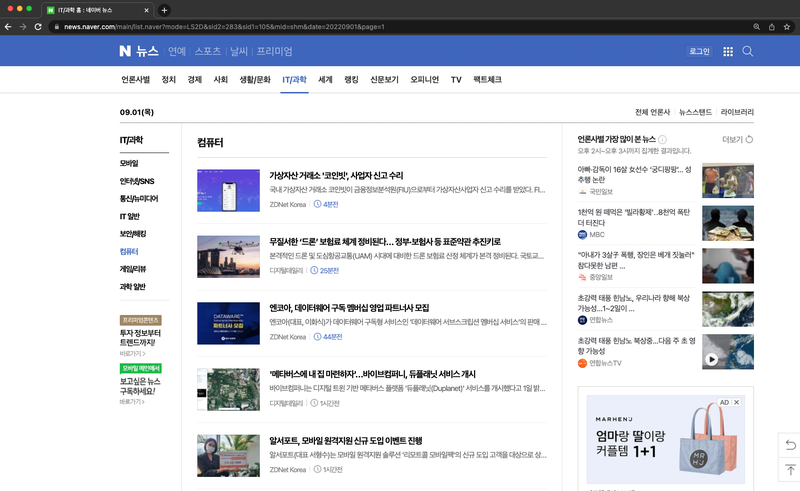

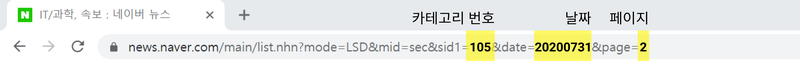

&sid1= 뒤에 있는 번호는 뉴스가 속한 카테고리의 번호를 의미한다. 각 번호가 의미하는 카테고리는 다음과 같다. 실제로 눌러보면서 카테고리 번호가 어떻게 변경되는지를 확인하면 된다.

100 : 정치

101 : 경제

102 : 사회

103 : 생활/문화

104 : 세계

105 : IT/과학

110 : 오피니언

&date= 뒤에 있는 날짜는 해당 뉴스들이 속한 날짜를 의미한다. 이 날짜를 변경함으로써 해당 날짜의 뉴스 기사가 있는 페이지로 이동할 수 있다.

&page= 뒤에 있는 번호는 몇 페이지인지를 의미한다. 1페이지에서 크롤링을 다 하면, 2페이지로 이동하여 크롤링하고, 이런 식으로 페이지를 이동할 수 있다.

#### 네이버 뉴스 HTML 문서 구조 이해하기

이제 원하는 카테고리, 날짜, 페이지를 접근할 수 있는 방법을 알았으니 해당 페이지에 있는 각 뉴스의 URL을 받아오는 방법이 필요하다. 각 뉴스 기사의 URL만 알고있으면 newspaper3k로 뉴스의 내용들을 가져올 수 있기 때문이다.

네이버 뉴스 기사 페이지에서 우클릭을 하여 '페이지 소스 보기'를 통해 HTML 문서를 열면 아래의 구조를 확인할 수 있다. 

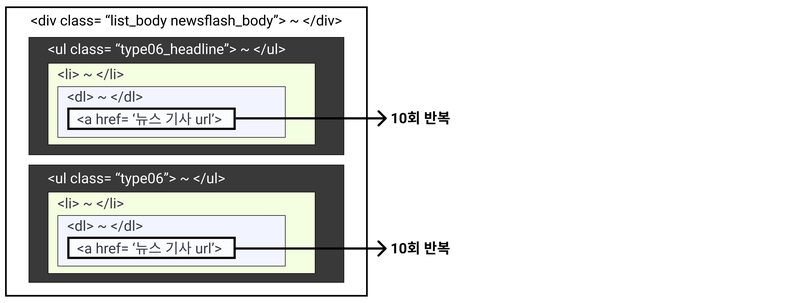

작은 사각형은 그보다 큰 사각형의 자식들이다. 이 구조만 파악하면, BeautifulSoup의 select()를 사용해서 네이버 뉴스 기사의 URL들을 받아올 수 있다.

### 네이버 뉴스 기사 크롤링 (2) BeautifulSoup와 newspapaer 3k를 통해 크롤러 만들기

아래 make_urllist는 BeautifulSoup라는 도구를 이용해서 URL 리스트를 리턴하는 함수이다. 원하는 페이지 수(page_num), 카테고리 번호(code), 날짜(date)를 입력값으로 받고 있다.

In [12]:
# 크롤러를 만들기 전 필요한 도구들을 임포트합니다.
import requests
import pandas as pd
from bs4 import BeautifulSoup

# 페이지 수, 카테고리, 날짜를 입력값으로 받습니다.
def make_urllist(page_num, code, date): 
  urllist= []
  for i in range(1, page_num + 1):
    url = 'https://news.naver.com/main/list.nhn?mode=LSD&mid=sec&sid1='+str(code)+'&date='+str(date)+'&page='+str(i)
    headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.90 Safari/537.36'}
    news = requests.get(url, headers=headers)

    # BeautifulSoup의 인스턴스 생성합니다. 파서는 html.parser를 사용합니다.
    soup = BeautifulSoup(news.content, 'html.parser')

    # CASE 1
    news_list = soup.select('.newsflash_body .type06_headline li dl')
    # CASE 2
    news_list.extend(soup.select('.newsflash_body .type06 li dl'))
        
    # 각 뉴스로부터 a 태그인 <a href ='주소'> 에서 '주소'만을 가져옵니다.
    for line in news_list:
        urllist.append(line.a.get('href'))
  return urllist

어디 한번 함수를 실행해 볼까? 2020년 5월 6일, 경제 기사(코드로 101번)를 2페이지까지 탐색해서 URL 리스트를 받아오겠다. 한 페이지당 뉴스 기사가 20개가 있으니까, 2페이지까지 탐색하면 총 40개의 URL 리스트를 받아와야 한다.

In [13]:
url_list = make_urllist(2, 101, 20200506)
print('뉴스 기사의 개수: ',len(url_list))

뉴스 기사의 개수:  40


총 40개의 URL이 존재하는 것을 확인할 수 있습니다. 5개만 출력해 보자.

In [14]:
url_list[:5]

['https://n.news.naver.com/mnews/article/057/0001451723?sid=101',
 'https://n.news.naver.com/mnews/article/057/0001451721?sid=101',
 'https://n.news.naver.com/mnews/article/057/0001451718?sid=101',
 'https://n.news.naver.com/mnews/article/003/0009849190?sid=101',
 'https://n.news.naver.com/mnews/article/057/0001451717?sid=101']

뉴스 URL들이 잘 저장되어져 있는 것을 확인할 수 있다. 뉴스 URL 리스트를 받아올 수 있다면, 이제 newspaper3k를 이용해서 뉴스 기사들을 파이썬으로 저장할 수 있다.

그런데 그 전에 현재는 함수를 호출할 때 각 카테고리의 번호로 호출하고 있는데, 앞으로 결과를 확인할 때 코드로부터 바로 어떤 카테고리인지 확인하기 쉽도록 code를 키, 실제 카테고리를 밸류로 가지는 딕셔너리를 만들어두겠다. 이번 실습에 사용할 카테고리들에 대해서만 생성했다.

In [15]:
idx2word = {'101' : '경제', '102' : '사회', '103' : '생활/문화', '105' : 'IT/과학'}

다음은 newspaper3k를 통해서 만들어진 함수로 URL 리스트와 해당 URL이 어떤 카테고리인지 코드를 알려주면 이를 통해 데이터프레임을 생성하는 함수이다.

In [16]:
from newspaper import Article

#- 데이터프레임을 생성하는 함수입니다.
def make_data(urllist, code):
  text_list = []
  for url in urllist:
    article = Article(url, language='ko')
    article.download()
    article.parse()
    text_list.append(article.text)

  #- 데이터프레임의 'news' 키 아래 파싱한 텍스트를 밸류로 붙여줍니다.
  df = pd.DataFrame({'news': text_list})

  #- 데이터프레임의 'code' 키 아래 한글 카테고리명을 붙여줍니다.
  df['code'] = idx2word[str(code)]
  return df

서 저장해둔 경제 카테고리(코드 101)의 40개의 URL 리스트로부터 데이터프레임을 생성한다.

In [17]:
data = make_data(url_list, 101)
#- 상위 10개만 출력해봅니다.
data[:10]

,news,code
0,고려은단이 5월을 맞아 응원 메시지를 공유하는 ‘5월 5글자로 응원 부탁해!’ 이벤...,경제
1,코리아나화장품의 민감성 피부를 위한 저자극 스킨케어 브랜드 '프리엔제'가 마르고 건...,경제
2,서울장수주식회사가 부드럽고 달콤한 맛으로 인기를 모으고 있는 생막걸리 ‘인생막걸리’...,경제
3,[서울=뉴시스] 오동현 기자 = 모바일 게임 기업 컴투스는 3D 모바일 야구 게임 ...,경제
4,모두에게 보여주고 싶은 기사라면?beta 이 기사를 추천합니다 버튼을 눌러주세요.\...,경제
5,"""요즘은 잔인한 날""…리프트도 앞서 982명 일시해고(뉴욕=연합뉴스) 이귀원 특파원...",경제
6,이재용 삼성전자 부회장(52)이 그룹 경영권 승계 과정에서 발생한 각종 불법·편법 ...,경제
7,JW중외제약이 A형 혈우병 예방요법제 ‘헴리브라피하주사를 출시하고 본격적인 마케팅 ...,경제
8,"옵티팜과 휴벳바이오가 공동 개발중인 백신 후보 물질에 대해 마우스, 기니피그, 미니...",경제
9,[한국경제TV 신동호 기자]\n\n전남 나주시와 충북 청주시가 방사광 가속기 구축사...,경제


40개의 경제 뉴스가 데이터프레임에 저장되었다.

### 네이버 뉴스 기사 크롤링 (3) 데이터 수집 및 전처리

이번에는 하나의 카테고리만이 아니라 카테고리의 뉴스들에 대해서도 수집을 하고자 한다. 가령, 특정 날짜의 사회, 생활/문화, IT/과학의 뉴스들을 수집해본다고 하자. 수집을 원하는 카테고리 코드들을 저장한 리시트를 만들어 두자.

In [18]:
code_list = [102, 103, 105]

code_list

[102, 103, 105]

이 코드 리스트, 그리고 날짜, 페이지 수를 입력으로 받는 make_total_date()라는 함수를 만든다. 이 함수는 내부적으로 앞서 만든 make_urlist 함수와 make_data 함수를 호출하도록 한다.

In [19]:
from multiprocessing import Pool
import random
import time, os

def make_total_data(page_num, code_list, date):
  start = int(time.time())  
  num_cores = 4  
  df = None
  for code in code_list:
    pool = Pool(num_cores)
    url_list = make_urllist(page_num, code, date)
    df_temp = make_data(url_list, code)
    print(str(code)+'번 코드에 대한 데이터를 만들었습니다.')
    pool.close()
    pool.join()
    time.sleep(random.randint(0,1))
    if df is not None:
      df = pd.concat([df, df_temp])
    else:
      df = df_temp

  print("***run time(sec) :", int(time.time()) - start)
  return df

마찬가지로 2020년 5월 6일 기사에 대해서 1페이지까지만 크롤링을 하되, 102번, 103번 105번 코드를 가지는 카테고리의 뉴스들을 수집해서 데이터프레임에 저장해 보겠다.

In [20]:
df = make_total_data(1, code_list, 20200506)

102번 코드에 대한 데이터를 만들었습니다.
103번 코드에 대한 데이터를 만들었습니다.
105번 코드에 대한 데이터를 만들었습니다.
***run time(sec) : 24


1페이지당 20개의 뉴스 기사가 존재하므로, 총 60개의 뉴스기사가 수집되어야 한다.

In [21]:
print('뉴스 기사의 개수: ',len(df))

뉴스 기사의 개수:  60


60개의 뉴스 기사가 수집되었다. 임의로 10개의 샘플을 선택하여 출력해 보겠다.

In [22]:
df.sample(10)

,news,code
9,(사진=PIXABAY)\n\n6일 국회에서 열린 과방위 법안소위의 모습. 코로나19...,IT/과학
7,1977년 메이저리그 LA 다저스의 시즌 마지막 경기였다. 신인 타자 더스티 베이커...,사회
3,귀갓길 여성을 쫓아가 성범죄를 시도한 20대 남성이 구속됐습니다.서울 강남경찰서는 ...,사회
2,[의정부=파이낸셜뉴스 강근주 기자] 황범순 의정부시 부시장은 4일 시공 중인 을지대...,사회
6,모두에게 보여주고 싶은 기사라면?beta 이 기사를 추천합니다 버튼을 눌러주세요.\...,생활/문화
2,나는 지난 30여년간 ‘협력(協力)’이라는 말을 매일 마주하며 살고 있다. 남북관계...,생활/문화
12,(서울=뉴스1) 강은성 기자 = 국민적 공분을 자아낸 n번방 사태의 재발을 막기 위...,IT/과학
3,[KBS 청주][앵커]충청북도가 한 차례 고배를 마셨던 방사광 가속기 유치에 다시 ...,IT/과학
16,"[아이뉴스24 민혜정, 송혜리 기자] 글로벌 콘텐츠업체(CP)에 망 안정성 의무를 ...",IT/과학
5,치열한 유치전이 벌어졌던 ‘4세대 방사광 가속기’ 설치 후보 지역이 전남 나주시와 ...,IT/과학


10개의 샘플을 출력해 보았는데, 3개의 카테고리가 전부 존재하는 것을 확인할 수 있다. df.sample(10)을 여러 번 호출하면서 달라지는 결과를 확인해보자. 수집한 데이터의 샘플들을 랜덤으로 여러 번 출력해 보는 것은 데이터를 파악하는 데 꽤 큰 도움이 된다.

이제 뉴스 크롤러가 완성되었다.

#### 크롤링

이번에는 좀 더 많은 데이터를 수집해보자. 이번에 수집한 데이터로 머신 러닝 모델을 통해 카테고리를 예측하는 모델을 만들어 보자. 이번에는 3개의 카테고리에 대해서 총 10개의 페이지에 대해서 크롤링하겠다.

In [23]:
df = make_total_data(10, code_list, 20200506)

102번 코드에 대한 데이터를 만들었습니다.
103번 코드에 대한 데이터를 만들었습니다.
105번 코드에 대한 데이터를 만들었습니다.
***run time(sec) : 250


뉴스 기사를 크롤링했다. 꽤 긴 시간을 들여서 수집한 데이터이기 때문에 실수로 유실하지 않도록 csv 파일을 별도로 저장해두겠다.

In [24]:
# 데이터프레임 파일을 csv 파일로 저장합니다.
# 저장경로는 이번 프로젝트를 위해 만든 폴더로 지정해 주세요.
csv_path = "/content/drive/MyDrive/newx_crawler/news_data.csv"
df.to_csv(csv_path, index=False)

if os.path.exists(csv_path):
  print('{} File Saved!'.format(csv_path))

/content/drive/MyDrive/newx_crawler/news_data.csv File Saved!


### 네이버 뉴스 기사 크롤링 (4) 데이터 전처리

크롤링과 데이터 추출을 통해 필요한 데이터를 얻었다. 하지만 이대로 머신 러닝 모델에 사용하기는 어렵다. 모델의 훈련에 사용하기 위해서는 우선 데이터를 정제하고, 그 다음 컴퓨터가 좋아하는 숫자의 형태로 바꾸어 주는 작업이 필요하다.

#### 데이터 정제

저장해둔 csv 파일을 다시 읽어서 데이터 프레임으로 저장하기 위해서는 아래의 코드를 사용한다.

In [25]:
csv_path = "/content/drive/MyDrive/newx_crawler/news_data.csv"
df = pd.read_table(csv_path, sep=',')
df.head()

,news,code
0,[파주=파이낸셜뉴스 강근주 기자] 파주시는 4일 관내 취약계층 1만9379가구에 대...,사회
1,이천 물류창고 화재 발화지점으로 지목된 지하 2층에서 산소절단기의 산소 공급 호스가...,사회
2,[의정부=파이낸셜뉴스 강근주 기자] 황범순 의정부시 부시장은 4일 시공 중인 을지대...,사회
3,귀갓길 여성을 쫓아가 성범죄를 시도한 20대 남성이 구속됐습니다.서울 강남경찰서는 ...,사회
4,(서울=연합뉴스) 대한약사회가 6일부터 코로나바이러스 감염증 대응 체계를 '사회적 ...,사회


이제 이 뉴스 데이터에 대해서 전처리를 진행해야 한다. 현재 저장된 뉴스 기사는 기본적으로 각종 숫자, 영어, \n과 같은 이스케이프 문자, HTML 태그들이 섞여 있다. 우선, 한글 외에는 전부 제거하도록 정규 표현식을 이용하여 전처리를 진행합니다.



In [26]:
# 정규 표현식을 이용해서 한글 외의 문자는 전부 제거합니다.
df['news'] = df['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", regex=True)
df['news']

0      파주파이낸셜뉴스 강근주 기자 파주시는 일 관내 취약계층 만가구에 대해 정부 긴급재난...
1      이천 물류창고 화재 발화지점으로 지목된 지하 층에서 산소절단기의 산소 공급 호스가 ...
2      의정부파이낸셜뉴스 강근주 기자 황범순 의정부시 부시장은 일 시공 중인 을지대학교 의...
3      귀갓길 여성을 쫓아가 성범죄를 시도한 대 남성이 구속됐습니다서울 강남경찰서는 강간상...
4      서울연합뉴스 대한약사회가 일부터 코로나바이러스 감염증 대응 체계를 사회적 거리두기에...
                             ...                        
595    지디넷코리아이도원 기자스마일게이트알피지대표 지원길는 블록버스터 핵앤슬래시 다중접속역...
596    서울뉴스 송화연 기자  공유버스 플랫폼 모두의셔틀은 신종 코로나바이러스 감염증코로나...
597    휴온스의 신종 코로나바이러스 감염증코로나 관련 방역용품이 미국 수출길에 오른다휴온스...
598    코로나 치료제백신 개발 범정부 지원단은 오늘일부터 이틀 동안 관련 기업들을 대상으로...
599      전자신문  전자신문인터넷 무단전재 및 재배포 금지이재용 삼성전자 부회장이 세 경...
Name: news, Length: 600, dtype: object

In [27]:
print(df.isnull().sum())

news    0
code    0
dtype: int64


In [28]:
# 중복된 샘플들을 제거합니다.
df.drop_duplicates(subset=['news'], inplace=True)

print('뉴스 기사의 개수: ',len(df))

뉴스 기사의 개수:  546


중복을 제거한 샘플의 개수가 데이터셋 전체 샘플 개수보다 적어진 것이 확인된다. 이 수치는 중복을 제거한 경우를 가정해서 카운트한 것으로 실제 중복을 제거하는 과정을 거쳐야만 실제로 정제된 데이터를 얻을 수 있다. (다시 한 번, 데이터의 수는 크롤링한 날짜에 따라 달라질 수 있습니다. 큰 차이가 없는 경우 그대로 진행하셔도 된다)

#### 데이터 탐색

이제 각 카테고리별 샘플의 분포를 확인해 보겠다.

참고로 환경에 따라 matplotlib에 한글 폰트가 적용되지 않아 글씨가 깨지거나 경고가 나타날 수 있다. 

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54924 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44284 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54617 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54876 missing from current font.
  font.set_

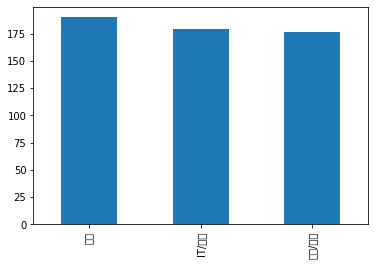

In [29]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "NanumGothic"

df['code'].value_counts().plot(kind = 'bar')

데이터는 사회 > 생활/문화 > IT/과학 순으로 뉴스 기사가 많았다. 실제 개수를 확인해 보자.

In [30]:
print(df.groupby('code').size().reset_index(name = 'count'))

    code  count
0  IT/과학    179
1     사회    190
2  생활/문화    177


#### 토큰화

이제 다시 뉴스 기사에 대한 전처리로 돌아가 보겠다. 자연어 처리에서 대부분의 경우 문자열은 특정 단위로 나누어져야만 한다. 자연어 처리에서는 이 특정 단위를 ‘토큰(token)’이라고 하며 이 과정을 토큰화(tokenization) 또는 토크나이징(tokenizing)이라고 한다. 영어의 경우, 일반적으로 띄어쓰기(whitespace)를 기준으로 토큰화를 진행하는 것만으로도 모델은 어느 정도 동작한다.

하지만 한국어는 영어와는 달리 띄어쓰기만으로는 토큰화에 한계가 있다. 그 이유는 한국어는 영어와는 달리 교착어이기 때문이다. 여기서 교착어란 조사, 어미 등을 붙여서 말을 만드는 언어를 의미한다. 예를 들어, '나(I/me)' 라는 주어나 목적어가 들어간 문장이 있다고 하자. 이 경우, ‘나’라는 단어 하나에도 ‘나는’, ‘나에게’, ’나를’, ’나와’ 같이 다양한 조사가 ‘나’ 라는 글자 뒤에 띄어쓰기 없이 바로 붙게 된다. 따라서 ‘나’ 라는 같은 의미를 지닌 단어임에도 불구하고, 붙은 조사에 따라 다른 단어로 인식될 수 있다.

위와 같은 문제를 해결하기 위해 한국어 자연어처리의 경우엔 형태소를 기준으로 토큰화를 수행하는 형태소 분석기를 사용한다. 대표적인 한국어 형태소 분석기로는 KoNLPy, kakao/khaiii, Mecab 등이 있으나, 오늘은 C/C++로 개발되고 동작이 빠른 Mecab을 사용해보겠다.

실습 전 미리 준비물로 설치한 형태소 패키지 라이브러리, Mecab의 사용법을 간단히 알아보겠다. Mecab의 .morphs를 사용하면 입력 문자열을 형태소 단위로 나누어준다.

In [31]:
! pip install --upgrade konlpy==0.5.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
from konlpy.tag import Mecab
tokenizer = Mecab()

kor_text = '밤에 귀가하던 여성에게 범죄를 시도한 대 남성이 구속됐다서울 제주경찰서는 \
            상해 혐의로 씨를 구속해 수사하고 있다고 일 밝혔다씨는 지난달 일 피해 여성을 \
            인근 지하철 역에서부터 따라가 폭행을 시도하려다가 도망간 혐의를 받는다피해 \
            여성이 저항하자 놀란 씨는 도망갔으며 신고를 받고 주변을 수색하던 경찰에 \
            체포됐다피해 여성은 이 과정에서 경미한 부상을 입은 것으로 전해졌다'

#- 형태소 분석, 즉 토큰화(tokenization)를 합니다.
print(tokenizer.morphs(kor_text))

Exception: ignored

입력된 문자열이 토큰화 된 것을 볼 수 있다. 자연어 처리에서는 토큰화 결과가 얼마나 정확한지에 따라 그 성능에 많은 영향을 받는다. 형태소 분석기의 결과가 머신 러닝 결과의 성능에 큰 영향을 주기도 한다.

#### 불용어 제거

이제 갖고 있는 데이터에 형태소 분석기를 사용하겠습다. 이렇게 토큰화 과정에서 해야 하는 전처리가 있다. 바로 불필요한 토큰들을 제거하는 불용어(stopwords) 제거이다. 불용어 란, 데이터 전체에서 꽤 많이 등장하지만 실제로는 자연어 처리에 큰 영향을 주지 않는, 중요하지 않은 단어들을 말한다. 한국어에서는 주로 ~가, ~은, ~는과 같은 조사나 접사 등이 불용어에 속한다. 또는 해당 데이터의 특성으로 인해 자주 등장할 수밖에 없는 단어들도 불용어이다.

이 데이터의 불용어를 정의해 보자.



In [ ]:
stopwords = ['에','는','은','을','했','에게','있','이','의','하','한','다','과','때문','할','수','무단','따른','및','금지','전재','경향신문','기자','는데','가','등','들','파이낸셜','저작','등','뉴스']

불용어는 미리 짐작하여 한 번에 정의하는 것이 아니라, 토큰화 과정을 거친 결과를 지속적으로 확인하면서 계속해서 추가하게 되는 것이 일반적이다. 위 불용어는 저자가 아래의 토큰화 함수를 몇 차례 실행 및 확인하면서 임의로 추가해 보았다. (실제로는 더 많은 불용어가 있을 것이다.)

In [ ]:
# 토큰화 및 토큰화 과정에서 불용어를 제거하는 함수입니다.
def preprocessing(data):
  text_data = []

  for sentence in data:
    temp_data = []
    #- 토큰화
    temp_data = tokenizer.morphs(sentence) 
    #- 불용어 제거
    temp_data = [word for word in temp_data if not word in stopwords] 
    text_data.append(temp_data)

  text_data = list(map(' '.join, text_data))

  return text_data

전체 데이터에 대해서 토큰화 및 불용어 제거를 수행한 뒤 첫 번째 샘플을 출력해 보자.

In [ ]:
text_data = preprocessing(df['news'])
print(text_data[0])

불용어가 제거된 상태로, 띄어쓰기 단위로 토큰화된 데이터라고 볼 수 있다.

### 머신 러닝 사용하기

머신러닝 모델 : 나이브 베이즈 분류기

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [ ]:
#- 훈련 데이터와 테스트 데이터를 분리합니다.
X_train, X_test, y_train, y_test = train_test_split(text_data, df['code'], random_state = 0)

In [ ]:
print('훈련용 뉴스 기사의 개수 :', len(X_train))
print('테스트용 뉴스 기사의 개수 : ', len(X_test))
print('훈련용 레이블의 개수 : ', len(y_train))
print('테스트용 레이블의 개수 : ', len(y_test))

기계는 텍스트보다는 숫자를 더 잘 처리한다. 머신 러닝 모델인 나이브 베이즈 분류기를 사용하기 위해서는 각 뉴스의 텍스트 데이터를 벡터로 변환할 필요가 있다. 이를 위한 전처리로 TF-IDF 라는 방법을 사용하겠다. 

이제 각 뉴스 문서를 TF-IDF 벡터로 바꾸고, 이를 통해 나이브 베이즈 분류기를 학습해 보겠다.

fit_transform() 함수는 fit과 transform을 연이어 수행하는 함수로, CountVectorizer.fit_transform()은 단어 데이터를 학습하고 문서 데이터를 document-form matrix로 변환하는 두 가지 작업을 해준다.

In [33]:
#- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#- 나이브 베이즈 분류기를 수행합니다.
#- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
clf = MultinomialNB().fit(X_train_tfidf, y_train)

NameError: ignored

나이브 베이즈 분류기가 학습되었다. 모델이 학습되었다면 그 다음 해야 할 일은 바로 '테스트'이다. 이 모델이 제대로 학습되었는지를 확인해 봐야죠? 텍스트를 입력하면 자동으로 TF-IDF 벡터로 바꾸는 전처리 함수를 만들어보겠다. 이 함수를 통해서 텍스트를 바로 나이브 베이즈 분류기의 입력으로 사용함으로써 보다 용이하게 테스트를 할 수 있다.

In [ ]:
def tfidf_vectorizer(data):
  data_counts = count_vect.transform(data)
  data_tfidf = tfidf_transformer.transform(data_counts)
  return data_tfidf

임의의 뉴스에 대해서 카테고리를 확인해 보자. 이 뉴스들은 훈련 데이터, 테스트 데이터 그 어디에도 속하지 않은, 네이버 뉴스 메뉴에서 임의로 가져온 뉴스이다. clf.predict() 는 임의의 입력에 대해서 나이브 베이즈 분류기가 예측한 값을 리턴한다.

In [ ]:
new_sent = preprocessing(["민주당 일각에서 법사위의 체계·자구 심사 기능을 없애야 한다는 \
                           주장이 나오는 데 대해 “체계·자구 심사가 법안 지연의 수단으로 \
                          쓰이는 것은 바람직하지 않다”면서도 “국회를 통과하는 법안 중 위헌\
                          법률이 1년에 10건 넘게 나온다. 그런데 체계·자구 심사까지 없애면 매우 위험하다”고 반박했다."])
print(clf.predict(tfidf_vectorizer(new_sent)))

내용을 봤을 때, 사회 뉴스로 예측한 것은 매우 합리적이다.

In [ ]:
new_sent = preprocessing(["인도 로맨틱 코미디 영화 <까립까립 싱글>(2017)을 봤을 때 나는 두 눈을 의심했다. \
                          저 사람이 남자 주인공이라고? 노안에 가까운 이목구비와 기름때로 뭉친 파마머리와, \
                          대충 툭툭 던지는 말투 등 전혀 로맨틱하지 않은 외모였다. 반감이 일면서 \
                          ‘난 외모지상주의자가 아니다’라고 자부했던 나에 대해 회의가 들었다.\
                           티브이를 꺼버릴까? 다른 걸 볼까? 그런데, 이상하다. 왜 이렇게 매력 있지? 개구리와\
                            같이 툭 불거진 눈망울 안에는 어떤 인도 배우에게서도 느끼지 못한 \
                            부드러움과 선량함, 무엇보다 슬픔이 있었다. 2시간 뒤 영화가 끝나고 나는 완전히 이 배우에게 빠졌다"])
print(clf.predict(tfidf_vectorizer(new_sent)))

영화 관련 뉴스에 대해서 생활/문화 뉴스로 예측한다.

In [ ]:
new_sent = preprocessing(["20분기 연속으로 적자에 시달리는 LG전자가 브랜드 이름부터 성능, 디자인까지 대대적인 변화를 \
                          적용한 LG 벨벳은 등장 전부터 온라인 커뮤니티를 뜨겁게 달궜다. 사용자들은 “디자인이 예쁘다”, \
                          “슬림하다”는 반응을 보이며 LG 벨벳에 대한 기대감을 드러냈다."])
print(clf.predict(tfidf_vectorizer(new_sent)))

LG전자의 LG 벨벳 뉴스에 대해서는 IT/과학 뉴스라고 예측하고 있다. 이제 테스트 데이터에 대해서 모델을 예측하게하고, 실제값과 비교하여 점수를 측정해 보겠다.

In [ ]:
y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

머신 러닝 모델의 성능 측정 방법 중 하나인 F1-스코어에서 81%라는 준수한 정확도를 얻어냈다!